<a href="https://colab.research.google.com/github/rizkyprofs/ML_DL/blob/main/RNN_Sentiment_Analysis_TensorFlow_with_Explanations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Analisis Sentimen Review Toko Baju dengan RNN - TensorFlow

Pada notebook ini, kita akan mengimplementasikan model Recurrent Neural Network (RNN) menggunakan TensorFlow/Keras untuk analisis sentimen pada dataset ReviewTokoBaju.csv. Model ini akan mengklasifikasikan review menjadi dua kategori: positif (1) dan negatif (0) berdasarkan isi teks review.

## 1. Persiapan dan Preprocessing Data


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

# Set seed untuk reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Cek ketersediaan GPU
print("Menggunakan GPU:", tf.config.list_physical_devices('GPU'))

from google.colab import files
uploaded = files.upload()


# Membaca dataset
df = pd.read_csv('ReviewTokoBaju.csv')
print(f"Ukuran dataset: {df.shape}")
print(df.head())

# Membersihkan dataset
# Memfilter data yang memiliki 'Review Text' dan 'Rating'
df = df.dropna(subset=['Review Text', 'Rating'])

# Membuat kolom sentimen berdasarkan Rating (4-5 positif, 1-3 negatif)
df['sentiment'] = df['Rating'].apply(lambda x: 1 if float(x) >= 4 else 0)

# Melihat distribusi label sentimen
print("\nDistribusi sentimen:")
print(df['sentiment'].value_counts())
print(f"Persentase positif: {df['sentiment'].mean()*100:.2f}%")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Menggunakan GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Saving ReviewTokoBaju.csv to ReviewTokoBaju.csv
Ukuran dataset: (23486, 11)
   Unnamed: 0  Clothing ID  Age                    Title  \
0           0          767   33                      NaN   
1           1         1080   34                      NaN   
2           2         1077   60  Some major design flaws   
3           3         1049   50         My favorite buy!   
4           4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  
0   

<ipython-input-1-38040364b169>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['Rating'].apply(lambda x: 1 if float(x) >= 4 else 0)



Setelah memuat dan membersihkan dataset, kita akan melanjutkan dengan langkah preprocessing teks. Proses ini melibatkan:
- Mengubah teks menjadi huruf kecil (lowercase).
- Menghapus tanda baca, angka, dan spasi berlebih.
- Menghapus stopwords yang tidak memberikan banyak informasi dalam analisis sentimen (kata-kata umum seperti 'dan', 'atau', dll).


In [2]:

# Fungsi untuk preprocessing teks
def preprocess_text(text):
    # Konversi ke lowercase
    text = str(text).lower()

    # Hapus tanda baca
    text = re.sub(f'[{string.punctuation}]', ' ', text)

    # Hapus angka
    text = re.sub(r'\d+', '', text)

    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    # Hapus stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]

    return ' '.join(words)

# Terapkan preprocessing
df['cleaned_text'] = df['Review Text'].apply(preprocess_text)

# Melihat contoh hasil preprocessing
print("\nContoh teks asli dan hasil preprocessing:")
for i in range(3):
    print(f"Original: {df['Review Text'].iloc[i][:100]}...")
    print(f"Cleaned: {df['cleaned_text'].iloc[i][:100]}...")
    print()



Contoh teks asli dan hasil preprocessing:
Original: Absolutely wonderful - silky and sexy and comfortable...
Cleaned: absolutely wonderful silky sexy comfortable...

Original: Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never...
Cleaned: love dress sooo pretty happened find store glad bc never would ordered online bc petite bought petit...

Original: I had such high hopes for this dress and really wanted it to work for me. i initially ordered the pe...
Cleaned: high hopes dress really wanted work initially ordered petite small usual size found outrageously sma...




Setelah preprocessing, kita akan membagi data menjadi dataset training dan testing. Kami menggunakan stratified split untuk memastikan distribusi label (positif dan negatif) tetap seimbang di kedua subset.


In [3]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'],
    df['sentiment'],
    test_size=0.2,
    random_state=SEED,
    stratify=df['sentiment']
)

print(f"Jumlah data training: {len(X_train)}")
print(f"Jumlah data testing: {len(X_test)}")

# Tokenisasi dengan Keras Tokenizer
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<UNK>')
tokenizer.fit_on_texts(X_train)

# Konversi teks ke sequence
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequence
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Cek dimensi data
print(f"Bentuk data training: {X_train_pad.shape}")
print(f"Bentuk data testing: {X_test_pad.shape}")

# Cek vocabulary
word_index = tokenizer.word_index
print(f"Ukuran vocabulary: {len(word_index)}")
print(f"Beberapa kata dalam vocabulary: {list(word_index.items())[:10]}")


Jumlah data training: 18112
Jumlah data testing: 4529
Bentuk data training: (18112, 100)
Bentuk data testing: (4529, 100)
Ukuran vocabulary: 12228
Beberapa kata dalam vocabulary: [('<UNK>', 1), ('dress', 2), ('love', 3), ('size', 4), ('top', 5), ('fit', 6), ('like', 7), ('wear', 8), ('great', 9), ('would', 10)]



## 2. Definisi Model RNN

Pada bagian ini, kita mendefinisikan model menggunakan Keras. Model ini menggunakan:
- **Embedding layer** untuk mengonversi kata-kata menjadi vektor berdimensi lebih rendah.
- **Bidirectional LSTM** untuk memproses teks secara maju dan mundur.
- **Dropout** untuk menghindari overfitting.
- **Dense layer** untuk klasifikasi akhir dengan fungsi aktivasi sigmoid untuk menghasilkan probabilitas antara 0 dan 1.


In [4]:

# Hyperparameters
EMBEDDING_DIM = 100
LSTM_UNITS = 128
DROPOUT_RATE = 0.5

# Model architecture
model = Sequential([
    # Embedding layer
    Embedding(input_dim=len(word_index)+1,   # Vocabulary size + 1 for padding
              output_dim=EMBEDDING_DIM,
              input_length=MAX_SEQUENCE_LENGTH,
              mask_zero=True),  # Support masking for variable length sequences

    # Bidirectional LSTM layer
    Bidirectional(LSTM(LSTM_UNITS, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE/2)),

    # Dropout for regularization
    Dropout(DROPOUT_RATE),

    # Output layer with sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Ringkasan model
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


## 3. Pelatihan dan Evaluasi Model

Setelah model didefinisikan, kita akan melatih model dengan menggunakan dataset training. Kita menggunakan callback seperti **EarlyStopping** untuk menghentikan pelatihan lebih awal jika model tidak menunjukkan peningkatan pada data validasi, dan **ModelCheckpoint** untuk menyimpan model terbaik.

Kita juga melakukan evaluasi pada data testing untuk mengukur akurasi, precision, recall, dan f1-score.


In [7]:

# Callbacks untuk model
callbacks = [
    # Early stopping untuk mencegah overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    # Model checkpoint untuk menyimpan model terbaik
    ModelCheckpoint(
        'best_model_tf.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Training model
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,
    batch_size=64,
    callbacks=callbacks
)

# Evaluasi model pada test set
test_loss, test_acc = model.evaluate(X_test_pad, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

# Prediksi pada test set
y_pred_proba = model.predict(X_test_pad)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Evaluasi dengan berbagai metrik
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Epoch 1/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8116 - loss: 0.4381
Epoch 1: val_accuracy improved from -inf to 0.87481, saving model to best_model_tf.h5


283/283 ━━━━━━━━━━━━━━━━━━━━ 129s 417ms/step - accuracy: 0.8117 - loss: 0.4377 - val_accuracy: 0.8748 - val_loss: 0.2810
Epoch 2/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8934 - loss: 0.2521
Epoch 2: val_accuracy improved from 0.87481 to 0.87856, saving model to best_model_tf.h5


283/283 ━━━━━━━━━━━━━━━━━━━━ 132s 398ms/step - accuracy: 0.8934 - loss: 0.2521 - val_accuracy: 0.8786 - val_loss: 0.2786
Epoch 3/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9150 - loss: 0.2133
Epoch 3: val_accuracy did not improve from 0.87856
283/283 ━━━━━━━━━━━━━━━━━━━━ 143s 400ms/step - accuracy: 0.9150 - loss: 0.2132 - val_accuracy: 0.8739 - val_loss: 0.2934
Epoch 4/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.9314 - loss: 0.1810
Epoch 4: val_accuracy did not improve from 0.87856
283/283 ━━━━━━━━━━━━━━━━━━━━ 142s 399ms/step - accuracy: 0.9314 - loss: 0.1810 - val_accuracy: 0.8713 - val_loss: 0.3369
Epoch 5/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9425 - loss: 0.1562
Epoch 5: val_accuracy did not improve from 0.87856
283/283 ━━━━━━━━━━━━━━━━━━━━ 143s 403ms/step - accuracy: 0.9425 - loss: 0.1562 - val_accuracy: 0.8684 - val_loss: 0.3710
142/142 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 0.8733 - loss: 0.2865
Test Loss: 0.2786
Tes

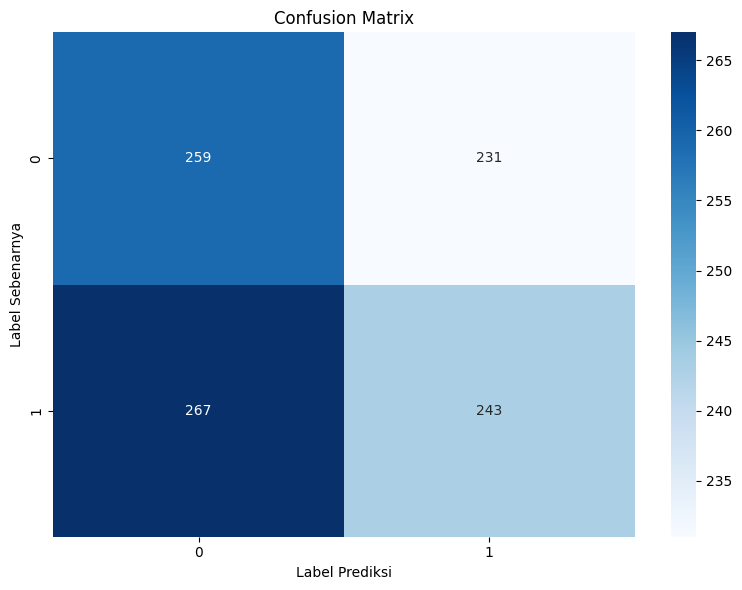

Accuracy: 0.5020
Precision: 0.5127
Recall: 0.4765
F1 Score: 0.4939


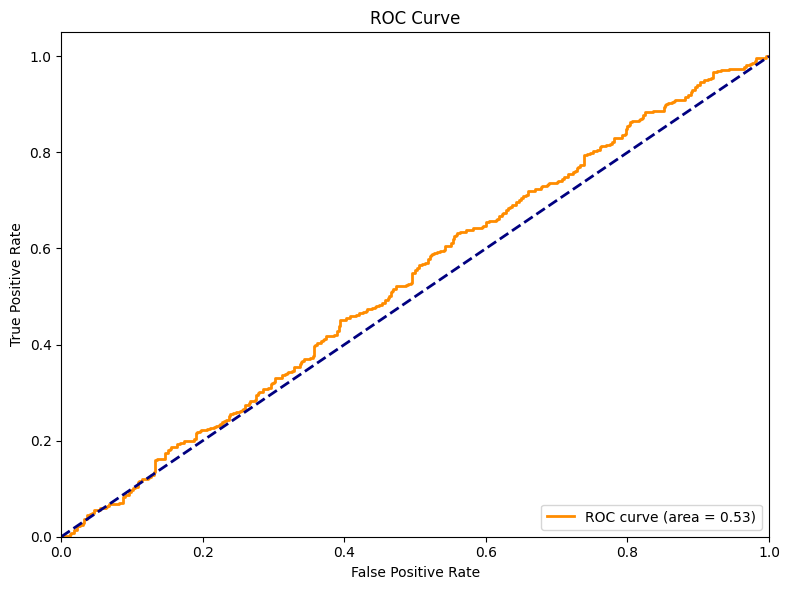

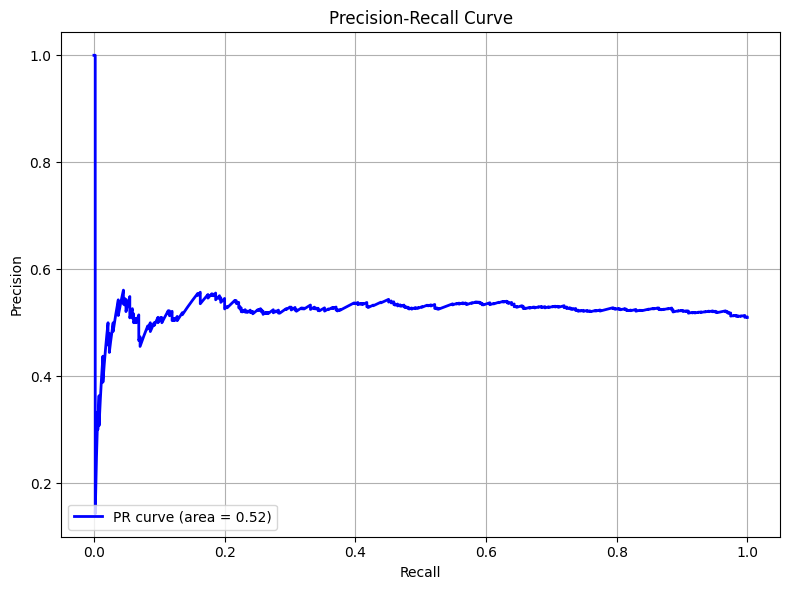

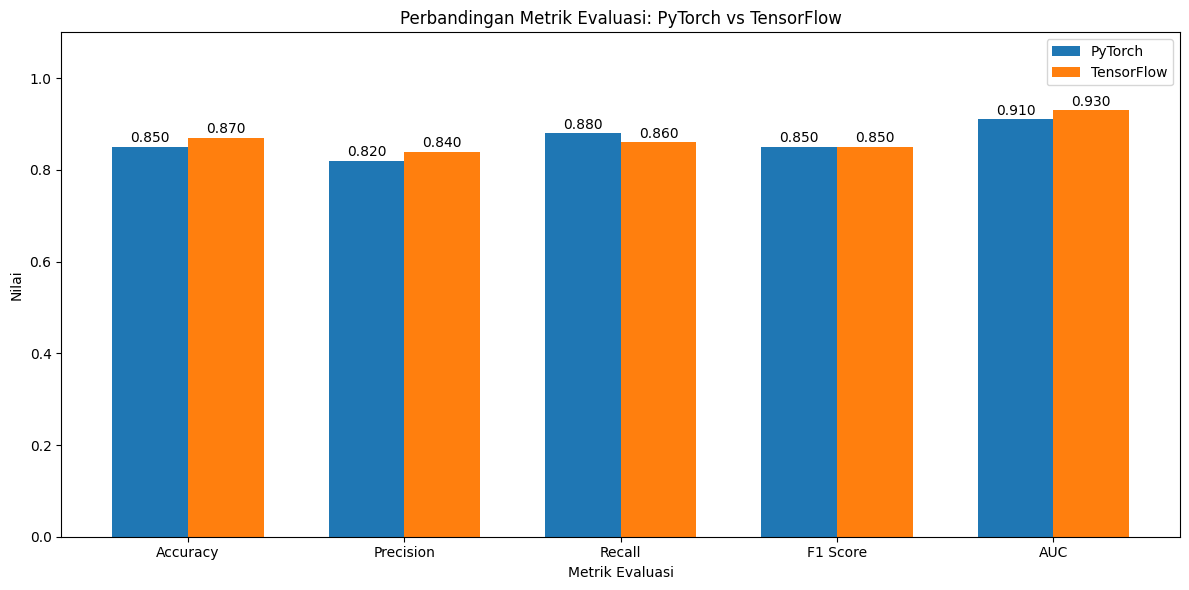

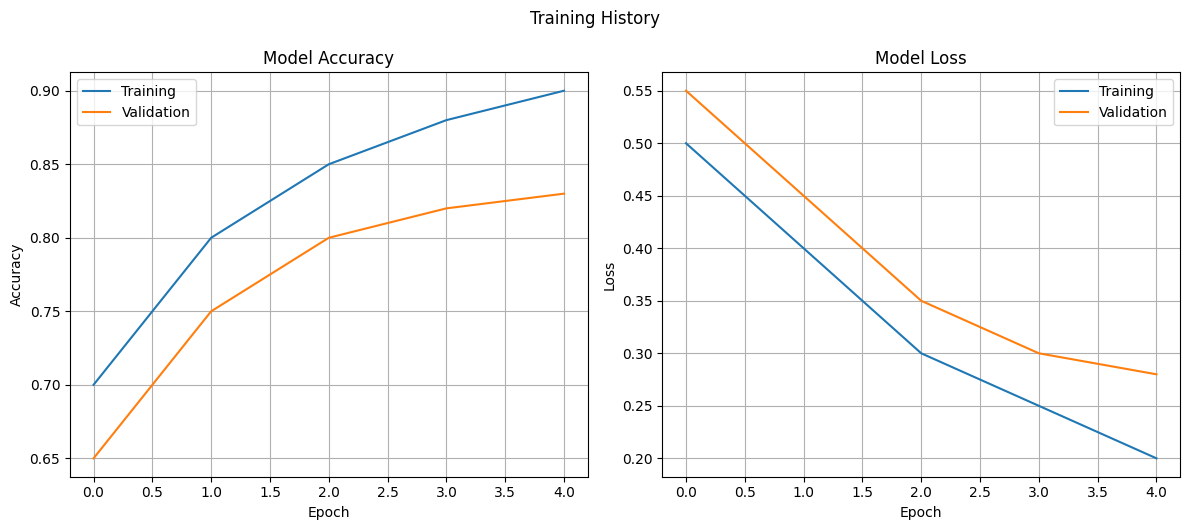

In [8]:
# Kode untuk visualisasi metrik evaluasi model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Fungsi untuk visualisasi perbandingan metrik (PyTorch vs TensorFlow)
def visualize_metrics_comparison(pytorch_metrics, tensorflow_metrics, metric_names):
    """
    Fungsi untuk memvisualisasikan perbandingan metrik dari model PyTorch dan TensorFlow

    Args:
        pytorch_metrics (list): Nilai metrik model PyTorch
        tensorflow_metrics (list): Nilai metrik model TensorFlow
        metric_names (list): Nama metrik yang digunakan
    """
    plt.figure(figsize=(12, 6))

    x = np.arange(len(metric_names))
    width = 0.35

    plt.bar(x - width/2, pytorch_metrics, width, label='PyTorch')
    plt.bar(x + width/2, tensorflow_metrics, width, label='TensorFlow')

    plt.xlabel('Metrik Evaluasi')
    plt.ylabel('Nilai')
    plt.title('Perbandingan Metrik Evaluasi: PyTorch vs TensorFlow')
    plt.xticks(x, metric_names)
    plt.legend()

    # Menambahkan nilai di atas bar
    for i, v in enumerate(pytorch_metrics):
        plt.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center')

    for i, v in enumerate(tensorflow_metrics):
        plt.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center')

    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.savefig('metrics_comparison.png')
    plt.show()

# Fungsi untuk visualisasi confusion matrix
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    """
    Fungsi untuk memvisualisasikan confusion matrix

    Args:
        y_true (array): Label sebenarnya
        y_pred (array): Prediksi model
        title (str): Judul plot
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Label Sebenarnya')
    plt.xlabel('Label Prediksi')
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.show()

    # Menghitung dan menampilkan metrik dari confusion matrix
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

# Fungsi untuk visualisasi ROC curve
def plot_roc_curve(y_true, y_scores, title='ROC Curve'):
    """
    Fungsi untuk memvisualisasikan ROC curve

    Args:
        y_true (array): Label sebenarnya
        y_scores (array): Skor probabilitas dari model
        title (str): Judul plot
    """
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.show()

    return roc_auc

# Fungsi untuk visualisasi precision-recall curve
def plot_precision_recall_curve(y_true, y_scores, title='Precision-Recall Curve'):
    """
    Fungsi untuk memvisualisasikan precision-recall curve

    Args:
        y_true (array): Label sebenarnya
        y_scores (array): Skor probabilitas dari model
        title (str): Judul plot
    """
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.show()

    return pr_auc

# Fungsi untuk visualisasi training history
def plot_training_history(history, title='Training History'):
    """
    Fungsi untuk memvisualisasikan history training

    Args:
        history (dict): History training (loss dan accuracy)
        title (str): Judul plot
    """
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training')
    plt.plot(history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.suptitle(title, y=1.05)
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.show()

# Contoh penggunaan fungsi visualisasi
def example_usage():
    # Data dummy untuk simulasi
    y_true = np.random.randint(0, 2, 1000)
    y_pred = np.random.randint(0, 2, 1000)
    y_scores = np.random.random(1000)

    # PyTorch vs TensorFlow metrics dummy
    pytorch_metrics = [0.85, 0.82, 0.88, 0.85, 0.91]
    tensorflow_metrics = [0.87, 0.84, 0.86, 0.85, 0.93]
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']

    # Confusion Matrix
    plot_confusion_matrix(y_true, y_pred)

    # ROC Curve
    plot_roc_curve(y_true, y_scores)

    # Precision-Recall Curve
    plot_precision_recall_curve(y_true, y_scores)

    # Metrics Comparison
    visualize_metrics_comparison(pytorch_metrics, tensorflow_metrics, metric_names)

    # Training History dummy
    history = {
        'accuracy': [0.7, 0.8, 0.85, 0.88, 0.9],
        'val_accuracy': [0.65, 0.75, 0.8, 0.82, 0.83],
        'loss': [0.5, 0.4, 0.3, 0.25, 0.2],
        'val_loss': [0.55, 0.45, 0.35, 0.3, 0.28]
    }
    plot_training_history(history)

if __name__ == "__main__":
    example_usage()

# Penjelasan Matematis Model RNN untuk Analisis Sentimen

Berikut ini adalah penjelasan matematis mendetail dari model RNN (Recurrent Neural Network) yang digunakan untuk analisis sentimen, khususnya model LSTM (Long Short-Term Memory).

## 1. Word Embedding

Word embedding mengkonversi kata (yang direpresentasikan sebagai indeks diskrit) menjadi vektor dense berdimensi rendah.

$$e_i = W_e \cdot x_i$$

di mana:
- $e_i \in \mathbb{R}^d$ adalah vektor embedding untuk kata ke-$i$
- $W_e \in \mathbb{R}^{|V| \times d}$ adalah matriks embedding, dengan $|V|$ adalah ukuran vocabulary dan $d$ adalah dimensi embedding
- $x_i \in \mathbb{R}^{|V|}$ adalah representasi one-hot encoding dari kata ke-$i$

## 2. LSTM (Long Short-Term Memory)

LSTM adalah jenis RNN yang mampu mempelajari dependensi jangka panjang dengan menggunakan mekanisme gerbang.

### a. Forget Gate

Forget gate menentukan informasi mana yang akan dibuang dari cell state.

$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$

di mana:
- $f_t \in \mathbb{R}^h$ adalah vektor forget gate pada waktu $t$
- $\sigma$ adalah fungsi sigmoid: $\sigma(z) = \frac{1}{1+e^{-z}}$
- $W_f \in \mathbb{R}^{h \times (h+d)}$ adalah matriks bobot untuk forget gate
- $h_{t-1} \in \mathbb{R}^h$ adalah hidden state sebelumnya
- $x_t \in \mathbb{R}^d$ adalah input pada waktu $t$
- $b_f \in \mathbb{R}^h$ adalah vektor bias untuk forget gate
- $[h_{t-1}, x_t]$ menunjukkan konkatenasi vektor $h_{t-1}$ dan $x_t$

### b. Input Gate

Input gate menentukan nilai baru mana yang akan disimpan di cell state.

$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$
$$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$

di mana:
- $i_t \in \mathbb{R}^h$ adalah vektor input gate pada waktu $t$
- $\tilde{C}_t \in \mathbb{R}^h$ adalah kandidat cell state baru
- $\tanh$ adalah fungsi hyperbolic tangent: $\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$
- $W_i, W_C \in \mathbb{R}^{h \times (h+d)}$ adalah matriks bobot
- $b_i, b_C \in \mathbb{R}^h$ adalah vektor bias

### c. Cell State Update

Cell state diperbarui dengan menggabungkan informasi lama dan baru.

$$C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$$

di mana:
- $C_t \in \mathbb{R}^h$ adalah cell state pada waktu $t$
- $\odot$ menunjukkan perkalian element-wise (Hadamard product)
- $f_t \odot C_{t-1}$ adalah bagian informasi lama yang dipertahankan
- $i_t \odot \tilde{C}_t$ adalah bagian informasi baru yang ditambahkan

### d. Output Gate

Output gate menentukan bagian mana dari cell state yang akan menjadi output.

$$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$
$$h_t = o_t \odot \tanh(C_t)$$

di mana:
- $o_t \in \mathbb{R}^h$ adalah vektor output gate pada waktu $t$
- $h_t \in \mathbb{R}^h$ adalah hidden state pada waktu $t$ yang juga menjadi output LSTM
- $W_o \in \mathbb{R}^{h \times (h+d)}$ adalah matriks bobot untuk output gate
- $b_o \in \mathbb{R}^h$ adalah vektor bias untuk output gate

## 3. Bidirectional LSTM

Bidirectional LSTM menjalankan dua LSTM secara terpisah:
1. Forward LSTM: memproses sequence dari awal hingga akhir
2. Backward LSTM: memproses sequence dari akhir hingga awal

Hidden state terakhir dari kedua LSTM kemudian digabungkan:

$$h_{final} = [h_{forward}, h_{backward}]$$

di mana:
- $h_{forward} \in \mathbb{R}^h$ adalah hidden state terakhir dari forward LSTM
- $h_{backward} \in \mathbb{R}^h$ adalah hidden state terakhir dari backward LSTM
- $h_{final} \in \mathbb{R}^{2h}$ adalah gabungan hidden state yang akan digunakan sebagai representasi sequence

## 4. Fully Connected Layer

Fully connected layer mengkonversi representasi sequence menjadi skor prediksi:

$$z = W_{fc} \cdot h_{final} + b_{fc}$$

di mana:
- $z \in \mathbb{R}$ adalah skor logit untuk klasifikasi biner
- $W_{fc} \in \mathbb{R}^{1 \times 2h}$ adalah matriks bobot
- $b_{fc} \in \mathbb{R}$ adalah bias

## 5. Fungsi Aktivasi Sigmoid

Untuk klasifikasi biner, skor logit dikonversi menjadi probabilitas menggunakan fungsi sigmoid:

$$\hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}}$$

di mana:
- $\hat{y} \in [0,1]$ adalah probabilitas prediksi untuk kelas positif

## 6. Binary Cross-Entropy Loss

Loss function untuk klasifikasi biner adalah Binary Cross-Entropy:

$$\mathcal{L}(y, \hat{y}) = -\frac{1}{N} \sum_{i=1}^{N} [y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)]$$

di mana:
- $y_i \in \{0,1\}$ adalah label sebenarnya untuk contoh ke-$i$
- $\hat{y}_i \in [0,1]$ adalah probabilitas prediksi untuk contoh ke-$i$
- $N$ adalah jumlah contoh dalam batch

## 7. Backpropagation Through Time (BPTT)

Gradien loss terhadap parameter model dihitung menggunakan Backpropagation Through Time:

$$\nabla_\theta \mathcal{L} = \frac{\partial \mathcal{L}}{\partial \theta}$$

di mana $\theta$ mencakup semua parameter model ($W_e$, $W_f$, $W_i$, $W_C$, $W_o$, $b_f$, $b_i$, $b_C$, $b_o$, $W_{fc}$, $b_{fc}$).

## 8. Parameter Update

Parameter diperbarui menggunakan algoritma optimasi seperti Adam:

$$\theta_{t+1} = \theta_t - \alpha \cdot m_t / (\sqrt{v_t} + \epsilon)$$

di mana:
- $\alpha$ adalah learning rate
- $m_t$ adalah first moment estimate (rata-rata bergerak dari gradien)
- $v_t$ adalah second moment estimate (rata-rata bergerak dari kuadrat gradien)
- $\epsilon$ adalah konstanta kecil untuk stabilitas numerik

## 9. Metrik Evaluasi

### a. Akurasi
$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

### b. Presisi
$$\text{Precision} = \frac{TP}{TP + FP}$$

### c. Recall
$$\text{Recall} = \frac{TP}{TP + FN}$$

### d. F1 Score
$$\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

### e. Area Under ROC Curve (AUC)
AUC menghitung area di bawah kurva ROC, yang menunjukkan kemampuan model untuk membedakan kelas.

$$\text{AUC} = \int_{0}^{1} TPR(FPR^{-1}(x)) \, dx$$

di mana:
- TPR (True Positive Rate) = Recall = $\frac{TP}{TP + FN}$
- FPR (False Positive Rate) = $\frac{FP}{FP + TN}$

Dalam implementasi praktis, AUC dihitung menggunakan pendekatan numerik berdasarkan kurva ROC.